<a href="https://colab.research.google.com/github/edologgerbird/deep-learning-project/blob/develop_edmund/Project_Notebook_V2_EDO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Caption Generator: Investigating the effects of the Attention Mechanism

Project by: Loh Hong Tak Edmund (S221545), Sim Wee Yang (S221547), Woo Jun Hao Bryan (S221526)


### Background

Image caption generation is the process of a computer being able to recognize the context of an image and annotating it with the relevant captions. Recent developments in artificial intelligence and natural language processing allowed image caption generation to gain traction amongst researchers. The applications of image captioning are extensive, and there are various related methods that allow us to achieve this task. We intend to narrow our research down to LSTMs, transformers and the attention mechanism.

This project asims to investigate the effects of the attention mechanism defined by the paper "Show, Attend, Tell" on the model's ability to generate captions. We will be testing two models - one that utilises attention-weighting on the encoded and decoded outputs, against one that simply uses equal weighting. The project will employ performance metrics BLEU (Bilingual Evaluation Understudy) Score and Rouge (Recall Oriented Understudy for Gisting Evaluation) to identify the best performing model (Dayal, 2022).

### Flickr8k

This project will explore Image Caption Generation using the Flickr8k dataset, which is a benchmark collection for sentence-based image description and search. This set contains 8,000 images that are each paired with five different captions which describes the entities and events within each respective picture.

### Acknowledgements

1. sgrvinod for his baseline implementation of the LSTM decoder mechanism


In [1]:
GLOVE_LOAD_FROM_PICKLE = True

### Setting up the Environment

Installing Relevent Modules

In [2]:
! pip install great_expectations ipywidgets rich seaborn torch datasets transformers tokenizers sentencepiece sacremoses rouge-score --quiet

     |████████████████████████████████| 5.2 MB 27.6 MB/s 
     |████████████████████████████████| 237 kB 80.5 MB/s 
     |████████████████████████████████| 451 kB 85.6 MB/s 
     |████████████████████████████████| 5.5 MB 81.3 MB/s 
     |████████████████████████████████| 7.6 MB 77.6 MB/s 
     |████████████████████████████████| 1.3 MB 79.0 MB/s 
     |████████████████████████████████| 880 kB 86.6 MB/s 
     |████████████████████████████████| 439 kB 76.4 MB/s 
     |████████████████████████████████| 793 kB 66.3 MB/s 
     |████████████████████████████████| 140 kB 74.0 MB/s 
     |████████████████████████████████| 109 kB 70.0 MB/s 
     |████████████████████████████████| 4.0 MB 78.3 MB/s 
     |████████████████████████████████| 1.6 MB 55.7 MB/s 
     |████████████████████████████████| 423 kB 88.2 MB/s 
     |████████████████████████████████| 9.8 MB 81.1 MB/s 
     |████████████████████████████████| 346 kB 92.4 MB/s 
     |████████████████████████████████| 273 kB 92.3 MB/s 
     |████████

Importing relevant modules

In [3]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rich
import random
from functools import partial
import pickle
import great_expectations as ge
import time

import glob
import os
from tqdm.notebook import tqdm
from collections import Counter
from typing import List, Tuple, Optional, Dict, Any
from pathlib import Path
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
import skimage

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary            
from torch.utils.data import Dataset
import torch.backends.cudnn as cudnn

from PIL import Image 

import transformers
import tokenizers
import datasets
import zipfile
from huggingface_hub import hf_hub_download

from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.translate.chrf_score import corpus_chrf
from rouge_score import rouge_scorer

import gc
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
gc.collect()

117

Setting up Device

In [5]:
cudnn.benchmark = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rich.print(f"Device: [red]{DEVICE}")

Device: cuda

Constants

In [6]:
RANDOM_STATE = 42
TRAIN_SIZE = 0.70 # 0.70
VAL_SIZE = 0.15 # 0.15
TEST_SIZE = 0.15
IMAGE_SIZE = 256
BATCH_SIZE = 32
NUM_WORKERS = 8
NUM_CAPTIONS_PER_IMAGE = 5

Setting up Google Drive for development on Colab

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
drive_path = 'drive/My Drive/'

### Loading the data

We first start by loading the data, where we consolidate the image file names present in the data set. We also load the captions file, which contains the 5 captions tagged to their respective images.

In [9]:
image_paths = glob.glob(f'{drive_path}data/flickr_8k_dataset/Images/*.jpg')
print("Total Images:\t", len(image_paths))

captions = pd.read_csv(f'{drive_path}data/flickr_8k_dataset/captions.txt')
images = [f'{drive_path}data/flickr_8k_dataset/Images/{i}' for i in captions.image.values]

print(images[:3])
captions.head()

Total Images:	 8091
['drive/My Drive/data/flickr_8k_dataset/Images/1000268201_693b08cb0e.jpg', 'drive/My Drive/data/flickr_8k_dataset/Images/1000268201_693b08cb0e.jpg', 'drive/My Drive/data/flickr_8k_dataset/Images/1000268201_693b08cb0e.jpg']


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [10]:
captions['caption'].apply(lambda x: len(x)).sort_values()

9305       1
33360      1
23226      7
34525      9
11363      9
        ... 
2596     162
16688    167
13244    170
2730     173
8049     199
Name: caption, Length: 40455, dtype: int64

### Data Sanity Check

Next, we perform preliminary data sanity checks to ensure the cleanliness and validity of the data. We will make use of the great_expectations (GE) package to assist in these checks.

In summary, we will perform the following checks:

1. No null values
2. Caption data are of appropriate types
3. No images listed in the captions file that are missing in the images folder, vice versa
4. Each image contains exactly 5 accompanying captions

In [11]:
def check_expectations(df, column, expectation):
  ge_df = ge.from_pandas(df)
  ge_result = ge_df.expect_column_values_to_be_in_set(column, expectation)

  return {
    "Outcome: ": ge_result["success"],
    "Results: ": ge_result["result"]
    }

In [12]:
check_expectations(captions, "image", [i.split("/")[-1] for i in image_paths]) # check if all image names in the captions df are present in the image_paths

{'Outcome: ': True,
 'Results: ': {'element_count': 40455,
  'missing_count': 0,
  'missing_percent': 0.0,
  'unexpected_count': 0,
  'unexpected_percent': 0.0,
  'unexpected_percent_total': 0.0,
  'unexpected_percent_nonmissing': 0.0,
  'partial_unexpected_list': []}}

In [13]:
caption_counts = captions.groupby("image").count()

check_expectations(caption_counts, "caption", [5]) # check that all images have 5 accompanying captions

{'Outcome: ': True,
 'Results: ': {'element_count': 8091,
  'missing_count': 0,
  'missing_percent': 0.0,
  'unexpected_count': 0,
  'unexpected_percent': 0.0,
  'unexpected_percent_total': 0.0,
  'unexpected_percent_nonmissing': 0.0,
  'partial_unexpected_list': []}}

In [14]:
assert(set(captions["image"]) == set([i.split("/")[-1] for i in image_paths]))

Data passes sanity checks. There are no null and missing values, and the columns contain the expected image files names and the number of accomanying captions per image.

### Visualising the Data

First, we would like to visualise a few sample images.

In [15]:
def get_sample_image(image_paths, n):
  sample_images_path = random.sample(image_paths,n)
  sample_images_name = [i.split('/')[-1] for i in sample_images_path] 
  return sample_images_path, sample_images_name

def show_image(image_path):
  image = imread(image_path)
  plt.imshow(image)
  plt.axis('off')

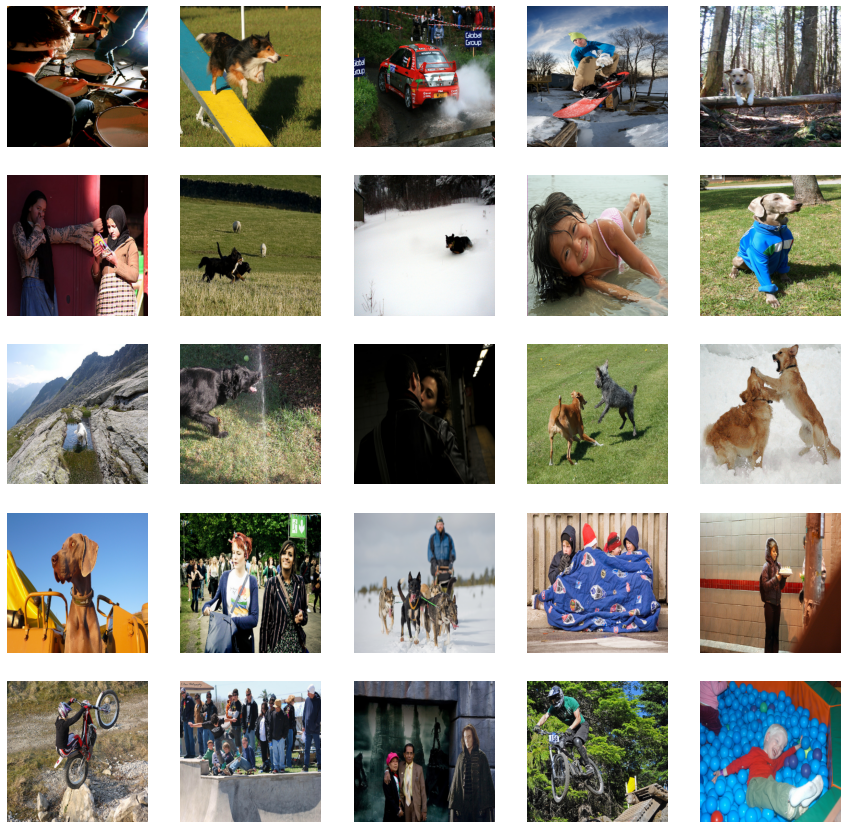

In [16]:
n_samples = 5*5
sample_images_path, sample_images_name = get_sample_image(image_paths,n_samples)

fig = plt.figure(figsize=(15, 15))

columns = 5
rows = 5

for i in range(len(sample_images_path)):
  image = imread(sample_images_path[i])
  image = skimage.img_as_ubyte(resize(image, (IMAGE_SIZE,IMAGE_SIZE)))
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(image)
  plt.axis('off')

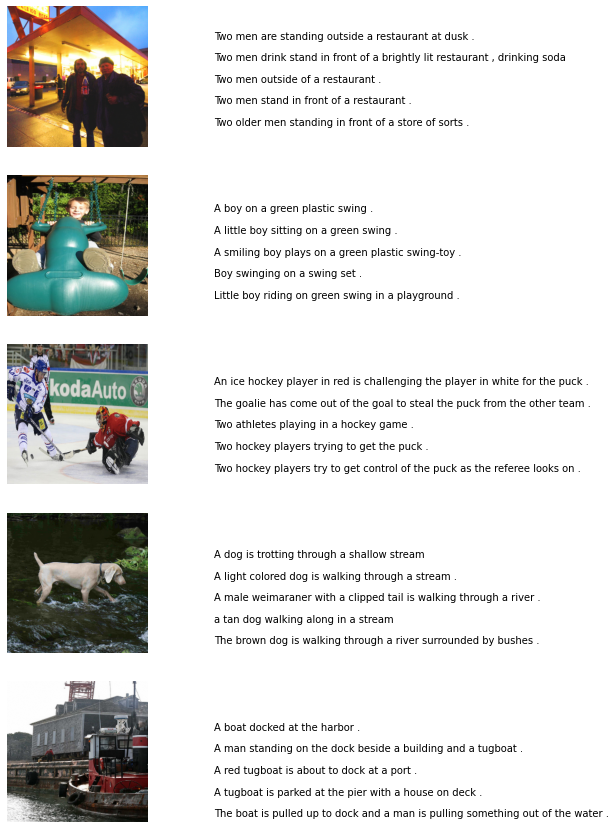

In [17]:
n_samples = 5
sample_images_path, sample_images_name = get_sample_image(image_paths,n_samples)

sample_images_captions = {i:captions[captions["image"] == i]["caption"].values for i in sample_images_name}

fig = plt.figure(figsize=(8, 15))

columns = 1
rows = 5

for i in range(len(sample_images_path)):
  image = imread(sample_images_path[i])
  image = resize(image, (IMAGE_SIZE,IMAGE_SIZE))
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(image)
  plt.axis('off')
  for enum, caption in enumerate(sample_images_captions[sample_images_name[i]]):
    plt.figtext(0.75,0.85+i*-0.16-0.02*enum, caption)

### Caption and Image Data Preparation

Due to the sequence generation nature of the model, we need to input special words indicating START, END, UKNOWN, PAD, to indicate when the sequence starts, ends, is an unseen word, or is a padding token respectively.

In [18]:
start_token = "<|start|>"
end_token = "<|end|>"
unknown_token = "<|unk|>"
pad_token = "<|pad|>"

special_tokens = [pad_token, start_token, end_token, unknown_token]

In [19]:
# Removing full stops at the end

def remove_full_stop(caption):
  if caption[-1] == '.':
    caption = caption[:-1]
  return caption

captions['caption'] = captions['caption'].apply(remove_full_stop) 

In [20]:
max_caption_length = max(captions["caption"].apply(lambda x: len(x.split())))

def add_special_tokens(caption):
  n_pads = max_caption_length - len(caption.split())
  updated_caption = start_token + " " + caption + " " + end_token + n_pads * (" " + pad_token)
  return updated_caption

In [21]:
captions['caption_pad'] = captions['caption'].apply(lambda x: add_special_tokens(x))
captions['caption_pad']

0        <|start|> A child in a pink dress is climbing ...
1        <|start|> A girl going into a wooden building ...
2        <|start|> A little girl climbing into a wooden...
3        <|start|> A little girl climbing the stairs to...
4        <|start|> A little girl in a pink dress going ...
                               ...                        
40450    <|start|> A man in a pink shirt climbs a rock ...
40451    <|start|> A man is rock climbing high in the a...
40452    <|start|> A person in a red shirt climbing up ...
40453    <|start|> A rock climber in a red shirt  <|end...
40454    <|start|> A rock climber practices on a rock c...
Name: caption_pad, Length: 40455, dtype: object

In [22]:
captions['caption_pad'][0]

'<|start|> A child in a pink dress is climbing up a set of stairs in an entry way  <|end|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>'

In [23]:
set(captions['caption_pad'].apply(lambda x: len(x.split())))

{39}

#### Loading GloVe Pretrained Embeddings

In [24]:
# control verbosity
transformers.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()

# define support functions
def load_glove_vectors(filename = "glove.6B.300d.txt") -> Tuple[List[str], torch.Tensor]:
    """Load the GloVe vectors. See: `https://github.com/stanfordnlp/GloVe`"""
    path = Path(hf_hub_download(repo_id="stanfordnlp/glove", filename="glove.6B.zip"))
    target_file = path.parent / filename
    if not target_file.exists():
        with zipfile.ZipFile(path, 'r') as zip_ref:
            zip_ref.extractall(path.parent)

        if not target_file.exists():
            print(f"Available files:")
            for p in path.parent.iterdir():
                print(p)
            raise ValueError(f"Target file `{target_file.name}` can't be found. Check if `{filename}` was properly downloaded.")

    # parse the vocabulary and the vectors
    vocabulary = []
    vectors = []
    with open(target_file, "r") as f:
        for l in tqdm(f.readlines(), desc=f"Parsing {target_file.name}..." ):
            word, *vector = l.split()
            vocabulary.append(word)
            vectors.append(torch.tensor([float(v) for v in vector]))
    vectors = torch.stack(vectors)
    return vocabulary, vectors

In [25]:
if not GLOVE_LOAD_FROM_PICKLE:
  # prepare data for the later cells
  glove_vocabulary, glove_vectors = load_glove_vectors()
  rich.print(f"glove_vocabulary: type={type(glove_vocabulary)}, length={len(glove_vocabulary)}")
  rich.print(f"glove_vectors: type={type(glove_vectors)}, shape={glove_vectors.shape}, dtype={glove_vectors.dtype}")

  # add special tokens
  special_tokens = [pad_token, start_token, end_token, unknown_token]
  glove_vocabulary = special_tokens + glove_vocabulary
  glove_vectors = torch.cat([torch.randn_like(glove_vectors[:len(special_tokens)]), glove_vectors])

  # tokenizer for GloVe
  glove_tokenizer = tokenizers.Tokenizer(tokenizers.models.WordLevel(vocab={v:i for i,v in enumerate(glove_vocabulary)}, unk_token=unknown_token))
  glove_tokenizer.normalizer = tokenizers.normalizers.BertNormalizer(strip_accents=False)
  glove_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.WhitespaceSplit()

  # glove_tokenizer
  with open(f'{drive_path}data/flickr_8k_dataset/tokenizer.gz', 'wb') as f: # "wb" because we want to write in binary mode
      pickle.dump(glove_tokenizer, f)
      print("SUCCESS: GLOVE tokeniser pickled successfully")

  # glove_vocab
  with open(f'{drive_path}data/flickr_8k_dataset/vocab.gz', 'wb') as f: # "wb" because we want to write in binary mode
      pickle.dump(glove_vocabulary, f)
      print("SUCCESS: GLOVE vocabulary pickled successfully")

  # glove vectors
  with open(f'{drive_path}data/flickr_8k_dataset/vectors.gz', 'wb') as f: # "wb" because we want to write in binary mode
      pickle.dump(glove_vectors, f)
      print("SUCCESS: GLOVE vectors pickled successfully")

else:
  with open(f'{drive_path}data/flickr_8k_dataset/tokenizer.gz', 'rb') as f: # "rb" because we want to read in binary mode
    glove_tokenizer = pickle.load(f)
    print("SUCCESS: GLOVE tokeniser loaded successfully")

  with open(f'{drive_path}data/flickr_8k_dataset/vocab.gz', 'rb') as f: # "rb" because we want to read in binary mode
    glove_vocabulary = pickle.load(f)
    print("SUCCESS: GLOVE vocabulary loaded successfully")

  with open(f'{drive_path}data/flickr_8k_dataset/vectors.gz', 'rb') as f: # "rb" because we want to read in binary mode
    glove_vectors = pickle.load(f)
    print("SUCCESS: GLOVE vectors loaded successfully")


SUCCESS: GLOVE tokeniser loaded successfully
SUCCESS: GLOVE vocabulary loaded successfully
SUCCESS: GLOVE vectors loaded successfully


In [26]:
emb_dim = glove_vectors.size(1)

In [27]:
# Encode the captions

captions['caption_ids'] = captions['caption_pad'].apply(lambda x: glove_tokenizer.encode(x).ids)

In [28]:
captions['caption_ids']

0        [1, 11, 968, 10, 11, 5495, 4639, 18, 6856, 64,...
1        [1, 11, 1753, 226, 79, 11, 4840, 451, 2, 0, 0,...
2        [1, 11, 337, 1753, 6856, 79, 11, 4840, 19623, ...
3        [1, 11, 337, 1753, 6856, 4, 12322, 8, 75, 1962...
4        [1, 11, 337, 1753, 10, 11, 5495, 4639, 226, 79...
                               ...                        
40450    [1, 11, 304, 10, 11, 5495, 5102, 15655, 11, 11...
40451    [1, 11, 304, 18, 1141, 6856, 156, 10, 4, 329, ...
40452    [1, 11, 903, 10, 11, 643, 5102, 6856, 64, 11, ...
40453    [1, 11, 1141, 20930, 10, 11, 643, 5102, 2, 0, ...
40454    [1, 11, 1141, 20930, 3253, 17, 11, 1141, 6856,...
Name: caption_ids, Length: 40455, dtype: object

Next, we split the images into train, validation and test data. The same image should not be present in the training, validation and test data sets. To ensure this, we will split the training and test sets by unique image names.

In [29]:
unique_image_names = list(set(captions["image"].values))

random.seed(RANDOM_STATE)

train_image_names = random.sample(unique_image_names, int(len(unique_image_names)*TRAIN_SIZE))
val_test_image_names = [image for image in unique_image_names if image not in train_image_names]
val_image_names = random.sample(val_test_image_names, int(len(unique_image_names)*VAL_SIZE))
test_image_names = [image for image in val_test_image_names if image not in val_image_names]


train_captions = captions[captions['image'].isin(train_image_names)].reset_index(drop=True)
val_captions = captions[captions['image'].isin(val_image_names)].reset_index(drop=True)
test_captions = captions[captions['image'].isin(test_image_names)].reset_index(drop=True)

print(f"Train Images: {len(train_image_names)}")
print(f"Validation Images: {len(val_image_names)}")
print(f"Test Images: {len(test_image_names)}")

print(f"Train Captions: {train_captions.shape[0]}")
print(f"Validation Captions: {val_captions.shape[0]}")
print(f"Test Captions: {test_captions.shape[0]}")

Train Images: 5663
Validation Images: 1213
Test Images: 1215
Train Captions: 28315
Validation Captions: 6065
Test Captions: 6075


In [30]:
train_captions["caption"].apply(lambda x: len(x.split()))

0        17
1         7
2         8
3         9
4        12
         ..
28310    10
28311     9
28312    15
28313     7
28314     9
Name: caption, Length: 28315, dtype: int64

Creating a custom dataloader class.

In [31]:
class ImageCaptionDataset(Dataset):

  def __init__(self, drive_path, image_names, captions, split, num_captions_per_image, transform=None):
    self.split = split
    self.image_names = captions['image']#image_names
    self.num_captions_per_image = num_captions_per_image
    self.captions_padded = captions['caption_pad']
    self.captions_ids = captions["caption_ids"]
    self.caption_lengths = captions["caption"].apply(lambda x: len(x.split()) + 2) 
    self.transform = transform
    self.dataset_size = self.captions_ids.size

  def __getitem__(self, caption_number):
    image_number = caption_number # // self.num_captions_per_image

    load_image = imread(f"{drive_path}data/flickr_8k_dataset/Images/"+self.image_names[image_number])
    load_image = skimage.img_as_ubyte(resize(load_image, (IMAGE_SIZE,IMAGE_SIZE)))
    #plt.imshow(load_image)
    #plt.show()

    image = torch.FloatTensor(load_image/255) #/255)
    image = image.permute(2,0,1) 

    if self.transform:
      image = self.transform(image)

    caption = torch.LongTensor(self.captions_ids[caption_number])
    caption_length = torch.LongTensor([self.caption_lengths[caption_number]])

    #print(self.captions_padded[caption_number])

    if self.split == 'TRAIN':
      return image, caption, caption_length

    else:
      # caption_ind = (caption_number // self.num_captions_per_image) * self.num_captions_per_image
      # print(self.captions_ids[caption_ind : caption_ind + self.num_captions_per_image])
      # all_captions = torch.LongTensor(
      #     self.captions_ids[caption_ind : caption_ind + self.num_captions_per_image]
      # )
      all_captions = torch.LongTensor(
          self.captions_ids[((i // self.num_captions_per_image) * self.num_captions_per_image):(((i // self.num_captions_per_image)*self.num_captions_per_image)+self.num_captions_per_image)]
      )
      return image, caption, caption_length, all_captions

  def __len__(self):
    return self.dataset_size

In [32]:
train_captions

,image,caption,caption_pad,caption_ids
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,<|start|> A child in a pink dress is climbing ...,"[1, 11, 968, 10, 11, 5495, 4639, 18, 6856, 64,..."
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building,<|start|> A girl going into a wooden building ...,"[1, 11, 1753, 226, 79, 11, 4840, 451, 2, 0, 0,..."
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse,<|start|> A little girl climbing into a wooden...,"[1, 11, 337, 1753, 6856, 79, 11, 4840, 19623, ..."
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,<|start|> A little girl climbing the stairs to...,"[1, 11, 337, 1753, 6856, 4, 12322, 8, 75, 1962..."
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,<|start|> A little girl in a pink dress going ...,"[1, 11, 337, 1753, 10, 11, 5495, 4639, 226, 79..."
...,...,...,...,...
28310,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,<|start|> A man in a pink shirt climbs a rock ...,"[1, 11, 304, 10, 11, 5495, 5102, 15655, 11, 11..."
28311,997722733_0cb5439472.jpg,A man is rock climbing high in the air,<|start|> A man is rock climbing high in the a...,"[1, 11, 304, 18, 1141, 6856, 156, 10, 4, 329, ..."
28312,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,<|start|> A person in a red shirt climbing up ...,"[1, 11, 903, 10, 11, 643, 5102, 6856, 64, 11, ..."
28313,997722733_0cb5439472.jpg,A rock climber in a red shirt,<|start|> A rock climber in a red shirt <|end...,"[1, 11, 1141, 20930, 10, 11, 643, 5102, 2, 0, ..."


In [33]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Mean and Std of ImageNet Channels



train_loader = torch.utils.data.DataLoader(
    ImageCaptionDataset(drive_path, train_image_names, train_captions, 'TRAIN', NUM_CAPTIONS_PER_IMAGE, transform=transforms.Compose([normalize])),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    ImageCaptionDataset(drive_path, val_image_names, val_captions, 'VAL', NUM_CAPTIONS_PER_IMAGE, transform=transforms.Compose([normalize])),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    ImageCaptionDataset(drive_path, test_image_names, test_captions, 'TEST', NUM_CAPTIONS_PER_IMAGE, transform=transforms.Compose([normalize])),
    batch_size=1, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

## Encoder

In this section, we will be defining the encoder class. This encoder will utilise the concept of transfer learning, where we will load the pretrained model VGG16. However, since we are not classifying the images at this stage, we will be modifying the last layer of the VGG16 network so that it will output the entire convolution feature set.

In [34]:
# Setting up the vgg16 model for transfer learning
vgg16 = models.vgg16_bn(weights="IMAGENET1K_V1").to(DEVICE)
print(f"Number of predicted features: {vgg16.classifier[6].out_features}")

# We freeze training for all layers in the vgg16 model
for param in vgg16.features.parameters():
    param.require_grad = False

# View layers in the VGG16 Model
summary(vgg16, (3, 224, 224))  

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Number of predicted features: 1000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
    

In [35]:
from torch.nn.modules import module
# Encoder Class

class Encoder(nn.Module):
  def __init__(self, encoded_image_size = 14):
    super(Encoder, self).__init__()
    self.encoded_image_size = encoded_image_size

    vgg16 = models.vgg16_bn(weights="IMAGENET1K_V1").to(DEVICE)
    # resnet = torchvision.models.resnet101(pretrained=True) 
    for param in vgg16.features.parameters():
      param.require_grad = False
    modules = list(vgg16.children())[:-2]
    self.vgg16 = nn.Sequential(*modules)
    self.adaptive_pool = nn.AdaptiveAvgPool2d((self.encoded_image_size, self.encoded_image_size))

  def forward(self, image_batch): 
    output = self.vgg16(image_batch)    # [batch_size, 512, image_size/32, image_size/32]
    output = self.adaptive_pool(output) # [batch_size, 512, encoded_image_size, encoded_image_size]
    output = output.permute(0,2,3,1)    # [batch_size, encoded_image_size, encoded_image_size, 512]
    return output


## Attention Module

In this section, we will define the attention mechanism. We use the soft-attention mechanism as decribed in "Show, Attend, Tell". The attention mechanism contains 2 linear layers to project the encoded and decoded outputs into the same dimensions. Just like an LSTM cell, the hidden decoded output is added to the encoded output before being passed through a squashing relu function. The subsequent output is then projected to a 1-dimensional tensor with another linear layer. This is then passed into the softmax function resulting in the attention weights. The encoded output is multiplied with the attention weights to obtain the attention weighted encoding, which describes which parts of the image to focus on.

Since we are testing the attention-weighted module against a mean-weighted weighting of the encoded image and decoded input, we define a toggle mean_weights to produce the weight matrix for both cases respectively.

In [36]:
class Attention(nn.Module):
  def __init__(self, encoder_dim, decoder_dim, attention_dim, mean_weights=False):
    super(Attention, self).__init__()
    self.encoder_att = nn.Linear(encoder_dim, attention_dim)
    self.decoder_att = nn.Linear(decoder_dim, attention_dim)
    self.projected_att = nn.Linear(attention_dim, 1)
    self.softmax = nn.Softmax(dim=1)
    self.relu = nn.ReLU()
    self.mean_weights = mean_weights

  def forward(self, encoder_output, decoder_hidden, mask=None):
    encoder_att_output = self.encoder_att(encoder_output)
    decoder_att_output = self.decoder_att(decoder_hidden)
    projected_att_output = self.projected_att(self.relu(encoder_att_output + decoder_att_output.unsqueeze(1))).squeeze(2)

    if not self.mean_weights:
      attention_weights = self.softmax(projected_att_output)
    else:
      attention_weights = torch.zeros_like(projected_att_output) + 1/projected_att_output.size(1)
      print(attention_weights)

    attention_weighted_encoding = (encoder_output * attention_weights.unsqueeze(2)).sum(dim=1)

    return attention_weighted_encoding, attention_weights


## Decoder Module

In this section, we define the decoder module. The decoder module utilises a LSTM-based approach in sequentially generating words based on the hidden  state of the previous timestep and the present cell state defined by the attention weighted encoded image. 

As we are sequentially decoding each word in each caption, we need to ensure that each caption is decoded up till and before the <|end|> token. To do this, we sort the captions in decending order based on caption length, and for each timestep only slice the tensor to obtain the batch of captions of length $<t$. Sorting allows us to efficiently retrieve the captions that satisfy the length requirement for each timestep.

In [37]:
class Decoder(nn.Module):
  def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, pre_trained_embeddings, encoder_dim=512, dropout=0.5, mean_weights=False):
    super(Decoder, self).__init__()

    self.attention_dim = attention_dim
    self.embed_dim = embed_dim
    self.decoder_dim = decoder_dim
    self.vocab_size = vocab_size
    self.encoder_dim = encoder_dim
    self.dropout = dropout
    self.attention_network = Attention(encoder_dim, decoder_dim, attention_dim, mean_weights=False)
    self.embedding = nn.Embedding(vocab_size, embed_dim)
    self.LSTM_decode = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)

    self.f_beta = nn.Linear(decoder_dim, encoder_dim)
    self.sigmoid = nn.Sigmoid()

    self.init_hidden = nn.Linear(encoder_dim, decoder_dim)
    self.init_cell =nn.Linear(encoder_dim, decoder_dim)
    self.vocab_layer = nn.Linear(decoder_dim, vocab_size)
    self.dropout = nn.Dropout(p=self.dropout)

    self.embedding.weight.data.uniform_(-0.1, 0.1)
    self.vocab_layer.bias.data.fill_(0)
    self.vocab_layer.weight.data.uniform_(-0.1,0.1)

    self.embedding.weight = nn.Parameter(pre_trained_embeddings)
    for p in self.embedding.parameters():
            p.requires_grad = True

  def forward(self, encoder_output, encoded_captions, caption_lengths):

    batch_size = encoder_output.size(0)
    encoder_dim = encoder_output.size(-1)

    encoder_output = encoder_output.view([batch_size, -1, encoder_dim])
    num_pixels = encoder_output.size(1)

    # sort
    caption_lengths_sorted, sort_index = caption_lengths.squeeze(1).sort(dim=0, descending=True)
    encoder_output_sorted = encoder_output[sort_index]
    encoded_captions_sorted = encoded_captions[sort_index]

    encoded_embeddings = self.embedding(encoded_captions_sorted)

    hidden_state = self.init_hidden(encoder_output_sorted.mean(dim=1))
    cell_state = self.init_cell(encoder_output_sorted.mean(dim=1))

    decode_target_lengths = (caption_lengths_sorted - 1).tolist()

    predictions = torch.zeros(batch_size, max(decode_target_lengths), self.vocab_size).to(DEVICE)
    attention_weights_all = torch.zeros(batch_size, max(decode_target_lengths), num_pixels).to(DEVICE)

    max_decode_length = max(decode_target_lengths)

    for timestep in range(max_decode_length):
      timestep_batch_size = sum([length > timestep for length in decode_target_lengths])
      attention_weighted_encoding, attention_weights = self.attention_network(encoder_output[:timestep_batch_size], hidden_state[:timestep_batch_size])
      
      gate = self.sigmoid(self.f_beta(hidden_state[:timestep_batch_size]))
      attention_weighted_encoding = gate * attention_weighted_encoding
      
      input_vector = torch.cat([encoded_embeddings[:timestep_batch_size, timestep, :], attention_weighted_encoding], dim=1)
      hidden_state, cell_state = self.LSTM_decode(input_vector, (hidden_state[:timestep_batch_size], cell_state[:timestep_batch_size]))
      preds = self.vocab_layer(self.dropout(hidden_state))
      predictions[:timestep_batch_size,timestep,:] = preds
      attention_weights_all[:timestep_batch_size, timestep, :] = attention_weights

    return predictions, encoded_captions_sorted, decode_target_lengths, attention_weights_all, sort_index


## Training

In this section, we will define the training function for each epoch. This is where batches of images and their corresponding captions will be encoded and decoded, and backpropagation performed to adjust the weights to minimise the loss. 

We will be using the optimizer Adam to backpropogate changes in the nueral network, and the loss function Cross Entropy Loss in the training proces.

In [38]:
class TrainingScoreHolder:
  def __init__(self):
    self.epoch = []
    self.training_loss = []
    self.training_top5_acc = []
    self.validation_loss = []
    self.validation_top5_acc = []
    self.validation_bleu4 = []
    self.validation_bleu3 = []
    self.validation_bleu2 = []

  def reset(self):
    self.epoch = []
    self.training_loss = []
    self.training_top5_acc = []
    self.validation_loss = []
    self.validation_top5_acc = []
    self.validation_bleu4 = []
    self.validation_bleu3 = []
    self.validation_bleu2 = []
    

In [39]:
def top_k_accuracy(scores, targets, k):

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

def clip_gradient(optimizer, grad_clip):

    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, decoder_optimizer,
                    bleu4, is_best, scores_holder):
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'bleu-4': bleu4,
             'encoder': encoder,
             'decoder': decoder,
             'decoder_optimizer': decoder_optimizer,
             'scores': scores_holder,             
             }
    filename = f'{drive_path}data/flickr_8k_dataset/' + data_name + '.pth.tar'
    torch.save(state, filename)
    # Save the best checkpoint to a separate file.
    if is_best:
        torch.save(state, f'{drive_path}data/flickr_8k_dataset/' + 'BEST_'+ data_name + '.pth.tar')


In [40]:
def train(train_loader, encoder, decoder, decoder_optimizer, criterion, epoch, scores_holder):
  
  encoder.train()
  decoder.train()

  batch_time = []
  data_time = []
  losses = []
  top5accs = []
  
  start_time = time.time()
  for i, (images, captions, caption_lengths) in enumerate(train_loader):
    gc.collect()
    torch.cuda.empty_cache()
    start_time = time.time()
    data_time.append(time.time() - start_time)

    images = images.to(DEVICE)
    captions = captions.to(DEVICE)
    caption_lengths = caption_lengths.to(DEVICE)

    # Forward Prop
    images = encoder(images)
    predictions, encoded_captions_sorted, decode_target_lengths, attention_weights_all, sort_index = decoder(images, captions, caption_lengths)

    targets = encoded_captions_sorted[:, 1:] # remove <|start|> token

    # Remove padding to reduce computation complexity
    predictions = pack_padded_sequence(predictions, decode_target_lengths, batch_first=True)[0]
    targets = pack_padded_sequence(targets, decode_target_lengths, batch_first=True)[0]

    
    loss = criterion(predictions, targets)

    # to implement doubly stochastic attention regularisation?
    loss += 1.0 * ((1. - attention_weights_all.sum(dim=1)) ** 2).mean()

    # Back propagation
    decoder_optimizer.zero_grad()
    #encoder_optimizer.zero_grad()
    loss.backward()

    if grad_clip is not None:
      clip_gradient(decoder_optimizer, grad_clip)

    decoder_optimizer.step()


    # metrics
    top_5_acc = top_k_accuracy(predictions, targets, 5)
    losses.append(loss.item()) 
    top5accs.append(top_5_acc)
    batch_time.append(time.time()-start_time)

    if i % 200 == 0:
      print('> TRAIN ================================================')
      print(f'Epoch: [{epoch}] [{i}/{len(train_loader)}]')
      print(f'Batch Time: {batch_time[-1]}')
      print(f'Data Load Time: {data_time[-1]}')
      print(f'Loss: {losses[-1]}')
      print(f'Average Loss: {np.mean(losses)}')
      print(f'Top 5 Accuracy: {top5accs[-1]}')
      print(f'Average Top 5 Accuracy: {np.mean(top5accs)}')
      print()

    start_time = time.time()
  
  scores_holder.epoch.append(epoch)
  scores_holder.training_loss.append(np.mean(losses))
  scores_holder.training_top5_acc.append(np.mean(top5accs))


## Validation

In this section, we will be defining the validation function, where will be evaluating the trained model at each epoch. We will be evaluating the models based on BLEU and ROUGE scores.

In [41]:
def validate(val_loader, encoder, decoder, criterion, scores_holder):

  decoder.eval()
  encoder.eval()

  batch_time = []
  losses = []
  top5accs = []

  start_time = time.time()

  references = [] # true text
  inferences = [] # predicted text

  with torch.no_grad():
    for i, (images, captions, caption_lengths, all_captions) in enumerate(val_loader):
      torch.cuda.empty_cache()

      images = images.to(DEVICE)
      captions = captions.to(DEVICE)
      caption_lengths = caption_lengths.to(DEVICE)

      images = encoder(images)
      predictions, encoded_captions_sorted, decode_target_lengths, attention_weights_all, sort_index = decoder(images, captions, caption_lengths)

      targets = encoded_captions_sorted[:, 1:]


      # Remove padding to reduce computation complexity
      predictions_copy = predictions.clone()
      predictions = pack_padded_sequence(predictions, decode_target_lengths, batch_first=True)[0]
      targets = pack_padded_sequence(targets, decode_target_lengths, batch_first=True)[0]

      # criterion = nn.CrossEntropyLoss().to(DEVICE)
      loss = criterion(predictions, targets)
      loss += 1.0 * ((1. - attention_weights_all.sum(dim=1)) ** 2).mean()

      # metrics
      top_5_acc = top_k_accuracy(predictions, targets, 5)
      losses.append(loss.item()) 
      top5accs.append(top_5_acc) 
      batch_time.append(time.time()-start_time)


      if i % 200 == 0:
        print('> VALIDATE ================================================')
        print(f'Epoch: [{epoch}] [{i}/{len(train_loader)}]')
        print(f'Batch Time: {batch_time[-1]}')
        print(f'Loss: {losses[-1]}')
        print(f'Average Loss: {np.mean(losses)}')
        print(f'Top 5 Accuracy: {top5accs[-1]}')
        print(f'Average Top 5 Accuracy: {np.mean(top5accs)}')
        print()

      # calculating BLEU

      # References
      all_captions = all_captions[sort_index]
      for j in range(all_captions.shape[0]):
        img_caps = all_captions[j].tolist()
        img_captions = list(
            map(lambda caption: [word for word in caption if word not in [0,1,2,3]],
            img_caps)
        )
        references.append(img_captions)

      # Inferences
      _, preds = torch.max(predictions_copy, dim=2)
      preds = preds.tolist()
      temp_preds = []
      for k, l in enumerate(preds):
        temp_preds.append(preds[k][:decode_target_lengths[k]])

      preds = temp_preds
      inferences.extend(preds)

      # Scoring

      assert(len(references) == len(inferences))

      bleu2_score = corpus_bleu(references, inferences,  weights = [(1./2. , 1./2.)])
      bleu3_score = corpus_bleu(references, inferences,  weights = [(1./3. , 1./3., 1./3.)])
      bleu4_score = corpus_bleu(references, inferences,  weights = [(1./4. , 1./4., 1./4., 1./4.)])

      scores_holder.validation_loss.append(np.mean(losses))
      scores_holder.validation_top5_acc.append(np.mean(top5accs))
      scores_holder.validation_bleu4.append(bleu4_score)
      scores_holder.validation_bleu3.append(bleu3_score)
      scores_holder.validation_bleu2.append(bleu2_score)

      return (bleu2_score, bleu3_score, bleu4_score) 

## Executing the Training and Validation Mechanism

We will engage early stopping based on the BLEU score. According to the paper, the loss and BLEU score are highly correlated (BLEU increases as loss decreases), but only up to a certain point where this relationship breaks down. At this stage, the loss may continue to decrease, but the BLEU will decrease as well. Hence, we will terminate training after the BLEU score shows signs of decay.

In [42]:
checkpoint = f'{drive_path}data/flickr_8k_dataset/' + "model_checkpoint" + '.pth.tar'
# checkpoint = None

In [ ]:
# Parameters

epochs = 150
decoder_lr = 4e-4
best_bleu4_attention = 0
epochs_since_improvement = 0
criterion = nn.CrossEntropyLoss().to(DEVICE)
grad_clip = 5.
start_epoch = 0 


if checkpoint is None:
  encoder = Encoder()
  decoder_attention = Decoder(emb_dim, emb_dim, emb_dim, len(glove_vocabulary), glove_vectors)
  decoder_attention_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder_attention.parameters()),
                                              lr=decoder_lr)
  scores_holder = TrainingScoreHolder()

else:
  checkpoint = torch.load(checkpoint)
  start_epoch = checkpoint['epoch'] + 1
  epochs_since_improvement = checkpoint['epochs_since_improvement']
  best_bleu4 = checkpoint['bleu-4']
  decoder_attention = checkpoint['decoder']
  decoder_attention_optimizer = checkpoint['decoder_optimizer']
  encoder = checkpoint['encoder']
  scores_holder = checkpoint['scores']

encoder = encoder.to(DEVICE)
decoder_attention = decoder_attention.to(DEVICE)


for epoch in range(start_epoch, epochs):

  if epochs_since_improvement > 20:
    break

  torch.cuda.empty_cache()
  gc.collect()
  train(train_loader=train_loader, encoder=encoder, decoder=decoder_attention, decoder_optimizer=decoder_attention_optimizer, criterion=criterion, epoch=epoch, scores_holder=scores_holder)
  torch.cuda.empty_cache()
  recent_bleu4_attention = validate(val_loader = val_loader, encoder = encoder, decoder = decoder_attention, criterion=criterion, scores_holder=scores_holder)
  print(recent_bleu4_attention)

  if recent_bleu4_attention[2] > best_bleu4_attention:
    best_bleu4_attention = recent_bleu4_attention[2]
    epochs_since_improvement = 0

  else:
    epochs_since_improvement += 1

  save_checkpoint("model_checkpoint", epoch, epochs_since_improvement, encoder, decoder_attention,
                        decoder_attention_optimizer, recent_bleu4_attention, recent_bleu4_attention[0] > best_bleu4_attention, scores_holder)


> TRAIN ================================================
Epoch: [81] [0/885]
Batch Time: 4.586856365203857
Data Load Time: 9.5367431640625e-07
Loss: 2.803297996520996
Average Loss: 2.803297996520996
Top 5 Accuracy: 80.29411764705883
Average Top 5 Accuracy: 80.29411764705883

> TRAIN ================================================
Epoch: [81] [200/885]
Batch Time: 0.48171544075012207
Data Load Time: 9.5367431640625e-07
Loss: 2.689281940460205
Average Loss: 2.804189902632984
Top 5 Accuracy: 82.11143695014663
Average Top 5 Accuracy: 81.73557649661889

> TRAIN ================================================
Epoch: [81] [400/885]
Batch Time: 0.7164349555969238
Data Load Time: 1.430511474609375e-06
Loss: 2.617549419403076
Average Loss: 2.80711368016174
Top 5 Accuracy: 83.91420911528151
Average Top 5 Accuracy: 81.62780043732317

> TRAIN ================================================
Epoch: [81] [600/885]
Batch Time: 0.6629667282104492
Data Load Time: 1.6689300537109375e-06
Loss: 2.8547248

In [ ]:
# Loading best model from training phase

best_model_cp = f'{drive_path}data/flickr_8k_dataset/' + 'BEST_'+ "model_checkpoint" + '.pth.tar'

best_model_cp = torch.load(best_model_cp)
start_epoch = best_model_cp['epoch'] + 1
epochs_since_improvement = best_model_cp['epochs_since_improvement']
best_bleu4 = best_model_cp['bleu-4']
decoder_attention = best_model_cp['decoder']
decoder_attention_optimizer = best_model_cp['decoder_optimizer']
encoder = best_model_cp['encoder']
scores_holder = best_model_cp['scores']


## Beam Search Mechanism

To ensure that our model could produce the best possible final sequence as far as possible, we will utilise a beam search mechanism to evaluate sequences generated from the top k words at each timestep. Since each subsequent word depends on the word generated before it, we want to find a set of words that result in the best overall sequence, and this may not be the same as picking the individual words with the max score at each time step.

For instance, there may be cases where picking the second best word for the first time step results in the generation of better predictions subsequently, resulting in an overall better sequence.

Hence, we will define a beam search function to locate this best sequence out of the top k choices for each word.

In [ ]:
def beam_search(k, decoder, encoder_output):
  
  encoded_image_size = encoder_output.size(1)
  encoder_dim = encoder_output.size(3)

  encoder_output = encoder_output.view(1, -1, encoder_dim)
  
  num_pixels = encoder_output.size(1)

  encoder_output = encoder_output.expand(k, num_pixels, encoder_dim)

  k_prev_words = torch.LongTensor([[glove_vocabulary.index("<|start|>")]] * k).to(DEVICE)

  seqs = k_prev_words

  top_k_scores = torch.zeros(k, 1).to(DEVICE)

  seqs_attention_weights = torch.ones(k, 1, encoded_image_size, encoded_image_size).to(DEVICE)

  complete_seqs = []
  complete_seqs_attention_weights = []
  complete_seqs_scores = []

  step = 1

  hidden_state = decoder.init_hidden(encoder_output.mean(dim=1))
  cell_state = decoder.init_cell(encoder_output.mean(dim=1))

  while True:
    # torch.cuda.empty_cache()
    embeddings = decoder.embedding(k_prev_words).squeeze(1)
    attention_weighted_encoding, attention_weights = decoder.attention_network(encoder_output, hidden_state)
    attention_weights = attention_weights.view(-1, encoded_image_size, encoded_image_size)

    gate = decoder.sigmoid(decoder.f_beta(hidden_state))
    attention_weighted_encoding = gate * attention_weighted_encoding

    # print(embeddings.size())
    # print(attention_weighted_encoding.size())
    hidden_state, cell_state = decoder.LSTM_decode(
        torch.cat([embeddings, attention_weighted_encoding], dim=1), (hidden_state, cell_state)
    )

    pred_scores = decoder.vocab_layer(hidden_state)
    pred_scores - torch.nn.functional.log_softmax(pred_scores, dim=1)

    pred_scores = top_k_scores.expand_as(pred_scores) + pred_scores

    if step == 1:
      top_k_scores, top_k_words = pred_scores[0].topk(k, 0 , True, True)
    else:
      top_k_scores, top_k_words = pred_scores.view(-1).topk(k, 0 , True, True)

    # return top_k_words, 1
    prev_word_inds = top_k_words / len(glove_vocabulary)
    next_word_inds = top_k_words % len(glove_vocabulary)

    seqs = torch.cat([seqs[prev_word_inds.long()], next_word_inds.unsqueeze(1)], dim=1)
    seqs_attention_weights = torch.cat([seqs_attention_weights[prev_word_inds.long()], attention_weights[prev_word_inds.long()].unsqueeze(1)], dim=1)

    incomplete_inds = [i for i, next_word in enumerate(next_word_inds) if next_word != glove_vocabulary.index("<|end|>")]
    complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

    if len(complete_inds) > 0:
      complete_seqs.extend(seqs[complete_inds].tolist())
      complete_seqs_attention_weights.extend(seqs_attention_weights[complete_inds].tolist())
      complete_seqs_scores.extend(top_k_scores[complete_inds])
      print(complete_seqs_scores)
    
    k -= len(complete_inds)

    if k == 0:
      print("broken here")
      break

    seqs = seqs[incomplete_inds]
    seqs_attention_weights = seqs_attention_weights[incomplete_inds]
    hidden_state = hidden_state[prev_word_inds[incomplete_inds].long()]
    cell_state = cell_state[prev_word_inds[incomplete_inds].long()]
    encoder_output = encoder_output[prev_word_inds[incomplete_inds].long()]
    top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
    k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

    if step > 50:
      print('too many')
      break
    step += 1

  max_index = complete_seqs_scores.index(max(complete_seqs_scores))


  return complete_seqs[max_index], complete_seqs_attention_weights[max_index]

## Model Testing

In this section, we test our trained model with the unseen test data of our dataset. We use the test loader as defined earlier. In the testing, we will utilise beam search to produce the best possible caption sequence for each image. 

In [ ]:
beam_size = 5

def test(test_loader, encoder, decoder, k):
  
  references = []
  inferences = []

  for i, (image, captions, caption_lengths, all_captions) in enumerate(test_loader):
    # torch.cuda.empty_cache()
    encoder.eval()
    decoder.eval()

    image = image.to(DEVICE)
    encoder_output = encoder(image)
    # print(encoder_output.size(3))
    complete_seqs, complete_seqs_attention_weights = beam_search(k, decoder, encoder_output)

    # return complete_seqs, complete_seqs_attention_weights
    
    img_caps = all_captions[0].tolist()
    img_captions = list(
        map(lambda caption: [word for word in caption if word not in [glove_vocabulary.index("<|start|>"), glove_vocabulary.index("<|end|>"), glove_vocabulary.index("<|pad|>")]], img_caps)
    )
    references.append(img_captions)

    inferences.append(
        [word for word in complete_seqs if word not in [glove_vocabulary.index("<|start|>"), glove_vocabulary.index("<|end|>"), glove_vocabulary.index("<|pad|>")]]
    )

  bleu4 = corpus_bleu(references, inferences)
  print(bleu4)
  return bleu4, inferences


In [ ]:
bleu4_score_test, inference = test(test_loader, encoder, decoder_attention, beam_size)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
[glove_vocabulary[i] for i in inference[0]]

### Image Captioning and Attention Visualisation

In this section, we will utilise our trained model to generate captions given an input image. We will also visualise the attention on the images, showing the location where the model focuses on during the decoding process.

In [ ]:
checkpoint = f'{drive_path}data/flickr_8k_dataset/' + "model_checkpoint" + '.pth.tar'

checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
epochs_since_improvement = checkpoint['epochs_since_improvement']
best_bleu4 = checkpoint['bleu-4']
decoder_attention = checkpoint['decoder']
decoder_attention_optimizer = checkpoint['decoder_optimizer']
encoder = checkpoint['encoder']
scores_holder = checkpoint['scores']

In [ ]:
def image_preprocess(image_path):
  load_image = imread(image_path)
  load_image = skimage.img_as_ubyte(resize(load_image, (IMAGE_SIZE,IMAGE_SIZE)))
  load_image = torch.FloatTensor(load_image/255) 
  load_image = load_image.permute(2,0,1)
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Mean and Std of ImageNet Channels
  transform = transforms.Compose([normalize])
  image = transform(load_image)
  return image.unsqueeze(0)

In [ ]:
def generate_caption(encoder, decoder, image_path, glove_vocabulary, beam_size=3):

  # Reading and processing image input
  image = image_preprocess(image_path).to(DEVICE)
  print(image.size())
  encoder_output = encoder(image)
  complete_seqs, complete_seqs_attention_weights = beam_search(beam_size, decoder, encoder_output)
  return complete_seqs, complete_seqs_attention_weights

In [ ]:
image_path = f'{drive_path}data/flickr_8k_dataset/unseen/unseen1.jpg'

In [ ]:
complete_seqs, complete_seqs_attention_weights = generate_caption(encoder, decoder_attention, image_path, glove_vocabulary)

In [ ]:
[glove_vocabulary[i] for i in complete_seqs]

In [ ]:
import matplotlib.cm as cm

def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.
    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb
    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    # image = imread(image_path)
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)
    # image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]
    alphas = torch.FloatTensor(alphas)
    plt.figure(figsize=(50,20))
    for t in range(len(words)):
        if t > 50:
            break
        
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=50)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

In [ ]:
visualize_att(image_path, complete_seqs, complete_seqs_attention_weights, glove_vocabulary)